In [1]:
import cv2
import torch
import h5py
import numpy as np
import imageio
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import time
from collections import defaultdict

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

/home/rook/.local/share/virtualenvs/sketch2code-rS5pvLAN/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
%reload_ext autoreload

from sketch2code.data_model import *
from sketch2code.datasets import *
from sketch2code.helpers import *
from sketch2code.synthesize_program import *
from sketch2code.visualization import *
from sketch2code.methods.lstm import *
from sketch2code.methods.dqn import *
from s1x_supervise_baseline import *
from s11_supervise_baseline import *

### Purpose

Supervised for program synthesis

### Prepare datasets

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#examples 1750
#examples 1250
#examples 250
#examples 250


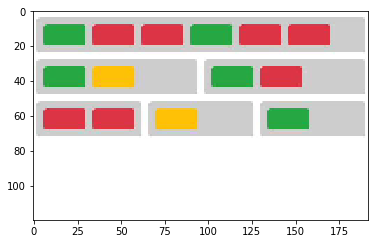

In [6]:
tags, oimages = load_dataset("toy")
print("#examples", len(tags))

def preprocess_img():
    global oimages
    return [shrink_img(img, 0.4, cv2.INTER_NEAREST).transpose((2, 0, 1)) for img in norm_rgb_imgs(oimages[:])]

images = cache_object("toy.shrink.imgs", preprocess_img)
plt.imshow(1 - images[0].transpose(1, 2, 0))

vocab, ivocab = make_toy_vocab_v1()
train_examples, valid_examples, test_examples = get_toy_dataset_v1(tags, vocab)

#examples 1750
img.shape (3, 256, 410)
|vocab| 24
#examples 1250
#examples 250
#examples 250
average length: 105.5504


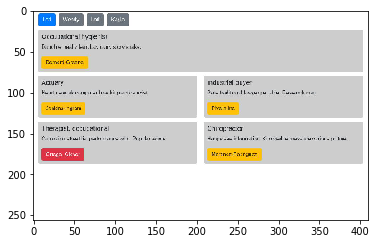

In [4]:
tags, oimages = load_dataset("pix2code")
print("#examples", len(tags))

def preprocess_img():
    global oimages
    return [shrink_img(img, 0.4, cv2.INTER_NEAREST).transpose((2, 0, 1)) for img in norm_rgb_imgs(oimages[:])]

images = cache_object("pix2code.shrink.imgs", preprocess_img)
print("img.shape", images[0].shape)
plt.imshow(1 - images[0].transpose(1, 2, 0))

vocab, ivocab = make_pix2code_vocab_v1()
print("|vocab|", len(vocab))
train_examples, valid_examples, test_examples = get_pix2code_dataset_v1(tags, vocab)
print("average length:", np.mean([len(e.context_tokens) for e in train_examples]))

In [5]:
# TODO: uncomment to use GPU
# images = torch.tensor(images, device=device)
images = torch.tensor(images)

### Define the model

In [6]:
encoder_dim=512
model = BLSuperV1(
    AttentionEncoderV1(img_h=images[0].shape[1], img_w=images[0].shape[2], encoder_dim=encoder_dim, encoded_img_h=14, encoded_img_w=14), 
    AttentionDecoderV1(encoder_dim=encoder_dim, attention_dim=256, dsl_vocab=vocab, dsl_embedding_dim=100, dsl_hidden_dim=256)).to(device)
print(model.train())

loss_func = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.3)

histories = train(
    model, loss_func, scheduler, optimizer, images, 
    (train_examples, valid_examples, test_examples), 
    clip_grad_val=5.,
    n_epoches=100, eval_valid_freq=1, eval_test_freq=5, batch_size=16,
    eval_batch_size=16,
    device=device, exp_dir='s11_exp')

BLSuperV1(
  (encoder): AttentionEncoderV1(
    (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 512, kernel_size=(5, 5), stride=(1, 1))
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (adaptive_pool): AdaptiveAvgPool2d(output_size=(14, 14))
  )
  (decoder): AttentionDecoderV1(
    (attention_lstm): AttentionLSTM(
      (attention): Attention(
        (encoder_att): Linear(in_features=512, out_features=256,

In [7]:
checkpoint = torch.load("/home/rook/workspace/CSCI559/Project/sketch2code/runs/s11_exp/run_15/model.bin")

encoder_dim=512
model = AttentionBLSuperV1(
    AttentionEncoderV1(img_h=images[0].shape[1], img_w=images[0].shape[2], encoder_dim=encoder_dim, encoded_img_h=14, encoded_img_w=14), 
    AttentionDecoderV1(encoder_dim=encoder_dim, attention_dim=256, dsl_vocab=vocab, dsl_embedding_dim=100, dsl_hidden_dim=256)).to(device)
model.load_state_dict(checkpoint['model'])

result = evaluate(model, nn.NLLLoss(), images, valid_examples, device, batch_size=50)
model.eval()
print('valid', {k: v.avg for k, v in result.items()})
result = evaluate(model, nn.NLLLoss(), images, test_examples, device, batch_size=50)
model.eval()
print('test', {k: v.avg for k, v in result.items()})

valid {'loss': 0.002679323024135117, 'top_1_acc': 0.9995497354695884, 'top_3_acc': 1.0, 'top_5_acc': 1.0}
test {'loss': 0.0028381246502540156, 'top_1_acc': 0.9994769092811239, 'top_3_acc': 1.0, 'top_5_acc': 1.0}


### Visualize what have learned in the network

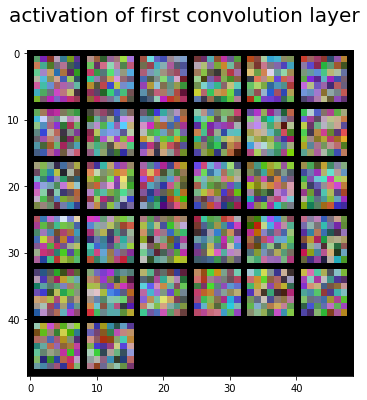

In [28]:
_ = viz_first_conv_layer(model.encoder.conv1, plt=plt, figsize=(6, 6), fontsize=20)

In [ ]:
res = viz_activation_layers(images[-1].to(device), model.encoder, padding=2, plt=plt, plt_config={
    'figsize': (16, 8),
    'subplot_size': (1, 3),
    'cmap': 'jet',
    'fontsize': 20
})

In [162]:
img = images[-1].to(device)
oimg = oimages[-1] / 255
bx, bxlen, sorted_idx = prepare_batch_sentences([test_examples[-1].context_tokens], device=device)
img = img.view(1, *img.shape).expand(bx.shape[0], *img.shape)

bnx_pred, alphas = model(img, bx, bxlen, return_alphas=True)
alphas = alphas[0].view(-1, 14, 14).detach().cpu().clone().numpy()
sentence = [ivocab[int(x)] for x in bx[0]]

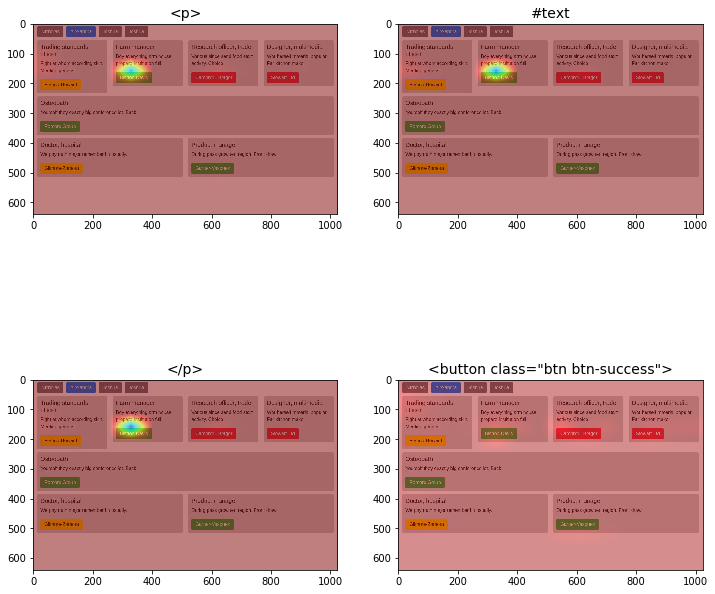

In [163]:
start_idx = 39
_ = viz_attention_map(oimg, alphas[start_idx:start_idx+4], sentence[start_idx:start_idx+4], 1, plt, {
    "figsize": (12, 12),
    "subplot_size": (2, 2)
})

In [220]:
class EncoderV1Extractor():
    """
    Class for extracting activations and registering gradients from targetted intermediate layers
    """

    def __init__(self, encoder):
        self.encoder = encoder
        self.gradients = []
    
    def save_gradient(self, grad):
        self.gradients.append(grad)
    
    def __call__(self, x):
        target_acts = []
        self.gradients = []
        
        x = self.encoder.pool1(F.selu(self.encoder.bn1(self.encoder.conv1(x))))
        x = self.encoder.pool2(F.selu(self.encoder.bn2(self.encoder.conv2(x))))
        
        x = F.selu(self.encoder.bn3(self.encoder.conv3(x)))
        x.register_hook(self.save_gradient)
        target_acts += [x]
        
        x = self.encoder.pool3(x)
        x = self.encoder.adaptive_pool(x)
        x = x.permute(0, 2, 3, 1)
        return target_acts, x
    
class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """
    def __init__(self, model):
        self.model = model
        self.feature_extractor = EncoderV1Extractor(self.model.encoder)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x1, x2, x2lens):
        target_acts, x1  = self.feature_extractor(x1)
        x2, alphas = self.model.decoder(x1, x2, x2lens)
        return target_acts, x2

    
class GradCam:
    def __init__(self, model):
        self.model = model
        self.model.eval()

        self.extractor = ModelOutputs(self.model)

    def __call__(self, x1, x2, x2lens, index = None):
        target_activations, output = self.extractor(x1, x2, x2lens)
        if index == None:
            # output is N x T x V, and because we only care about the last hidden layer
            index = torch.argmax(output[0, -1])
        
        one_hot = torch.zeros((1, output.shape[-1]), device=x1.device)
        one_hot[0, index] = 1
#         one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
        one_hot = torch.sum(one_hot * output[0, -1])
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        
        target = target_activations[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis = (2, 3))[0, :]
        cam = np.zeros(target.shape[1 : ], dtype = np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (410, 256))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam
    
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

In [222]:
img = images[0].to(device)
bx, bxlen, sorted_idx = prepare_batch_sentences([train_examples[0].context_tokens[:4]], device=device)
img = img.view(1, *img.shape).expand(bx.shape[0], *img.shape)
print('program:', [ivocab[w.item()] for w in bx[0]])

program: ['<program>', '<div class="container-fluid">', '<div class="row">', '<div class="col-12">']


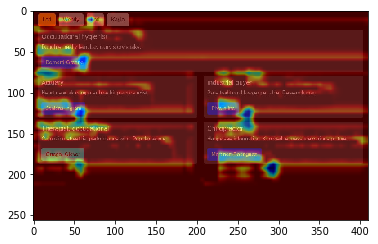

In [223]:
grad_cam = GradCam(model)
cam = grad_cam(img, bx, bxlen)
oimg = img[0].detach().cpu().clone().numpy().transpose((1, 2, 0))
plt.imshow(show_cam_on_image(oimg, cam))

### Evaluate

In [11]:
render_engine = RemoteRenderEngine.get_instance(tags[0].to_html(), oimages[0].shape[1], oimages[0].shape[0])

In [12]:
torch.cuda.empty_cache()
print('allocated:', torch.cuda.memory_allocated() / 1024 / 1024)
print('cache    :', torch.cuda.memory_cached() / 1024 / 1024)

allocated: 7439.1220703125
cache    : 7493.5


In [11]:
del scheduler
del model
del optimizer
del loss_func

Test the function on one image first

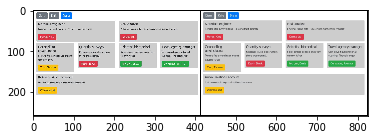

In [14]:
target_img, tag, oimage = images[-2], tags[-2], oimages[-2]
developer = BasicDeveloper(model, 32, tag, oimage)
plt.imshow(viz_grid(np.stack([1 - target_img.clone().cpu().numpy().transpose(1, 2, 0), shrink_img(1 - norm_rgb_imgs(oimage), 0.4)]), padding=2))

In [15]:
results = synthesize(
    target_img.to(device), ivocab, vocab,
    developer.predict_next_tokens,
    developer.should_stop,
    developer.search_guidance,
    branch_factor=3, 
    beam_width=3, 
    max_depth=150, report_tqdm=True)
results.sort(key=lambda x: x.prob, reverse=True)
print("#results", len(results))
gprog = [vocab[w] for w in tag.linearize(replace_text=True).str_tokens]
pprog = [vocab[w] for w in results[0].to_linearized_tag().str_tokens]
accuracy_measure(gprog, pprog)


#results 1


1.0

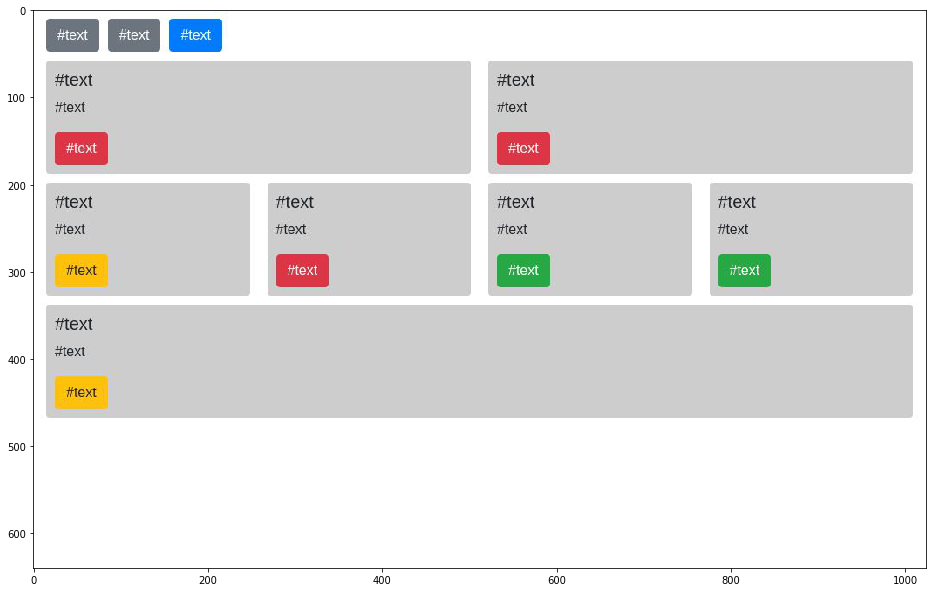

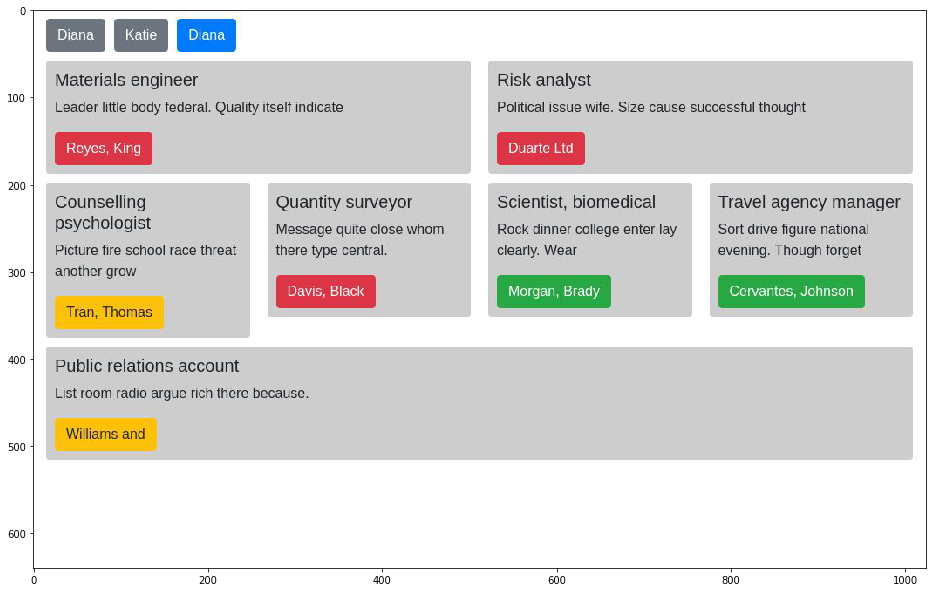

In [17]:
plt.figure(figsize=(16, 16))
plt.imshow(results[0].render_img(render_engine))
plt.figure(figsize=(16, 16))
plt.imshow(oimage)

#### Run this for final accuracy

In [11]:
accuracies = []
for e in tqdm(test_examples):
    target_img = images[e.img_idx].to(device)
    tag = tags[e.img_idx]
    oimage = oimages[e.img_idx]
    
    developer = BasicDeveloper(50, tag, oimage)
    results = synthesize(
        target_img, ivocab, vocab,
        developer.predict_next_tokens,
        developer.should_stop,
        developer.search_guidance,
        branch_factor=3, 
        beam_width=3, 
        max_depth=150, report_tqdm=False)
    results.sort(key=lambda x: x.prob, reverse=True)
    gprog = [vocab[w] for w in tag.linearize(replace_text=True).str_tokens]
    pprog = [vocab[w] for w in results[0].to_linearized_tag().str_tokens]
    accuracies.append(accuracy_measure(gprog, pprog))
    
print("accuracy", np.mean(accuracies))


accuracy 0.9908705804913939


In [112]:
ivocab

{0: '<pad>',
 1: '<program>',
 2: '</program>',
 3: '<div class="row">',
 4: '<div class="col-12">',
 5: '<div class="col-6">',
 6: '<div class="col-3">',
 7: '<div class="container-fluid">',
 8: '<div class="grey-background">',
 9: '<button class="btn btn">',
 10: '<button class="btn btn-danger">',
 11: '<button class="btn btn-warning">',
 12: '<button class="btn btn-success">',
 13: '<button class="btn btn-primary">',
 14: '<button class="btn btn-secondary">',
 15: '</div>',
 16: '</button>',
 17: '<nav>',
 18: '</nav>',
 19: '<h5>',
 20: '</h5>',
 21: '<p>',
 22: '</p>',
 23: '#text'}

#### DEBUG the program

Printing the image and allowing to discover next tags from the current program

['<program>', '<div class="container-fluid">', '<div class="row">', '<div class="col-4">', '<div class="grey-background">']
token_idx | next_token_str                                    | prob
       12 | <button class="btn btn-warning">                  | 0.36612
       13 | <button class="btn btn-success">                  | 0.32509
       11 | <button class="btn btn-danger">                   | 0.30744
        9 | <div class="grey-background">                     | 0.00032
       14 | </button>                                         | 0.00023
        4 | <div class="col-12">                              | 0.00023
        6 | <div class="col-4">                               | 0.00018
        5 | <div class="col-6">                               | 0.00009
       10 | </div>                                            | 0.00007
        2 | </program>                                        | 0.00006
        7 | <div class="col-3">                               | 0.00005
        8 | <di

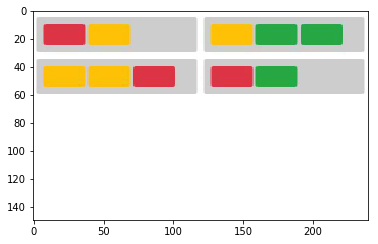

In [37]:
plt.imshow(1 - images[0].clone().detach().cpu().numpy().transpose(1, 2, 0))
program = HTMLProgram.from_int_tokens([1, 8, 3, 6, 9], ivocab)
print([ivocab[w] for w in program.to_int_tokens(vocab)])

program.print_next_tags(images[0], next_token_func, ivocab, vocab, device)